In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer,MaxAbsScaler
from sklearn.mixture import BayesianGaussianMixture
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [2]:
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv")

In [3]:
data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
sub.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [5]:
data.shape

(98000, 30)

In [6]:
sub.shape

(98000, 2)

**EDA**

In [7]:
data.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,...,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,...,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,...,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,...,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,...,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,...,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,...,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,...,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


<AxesSubplot:>

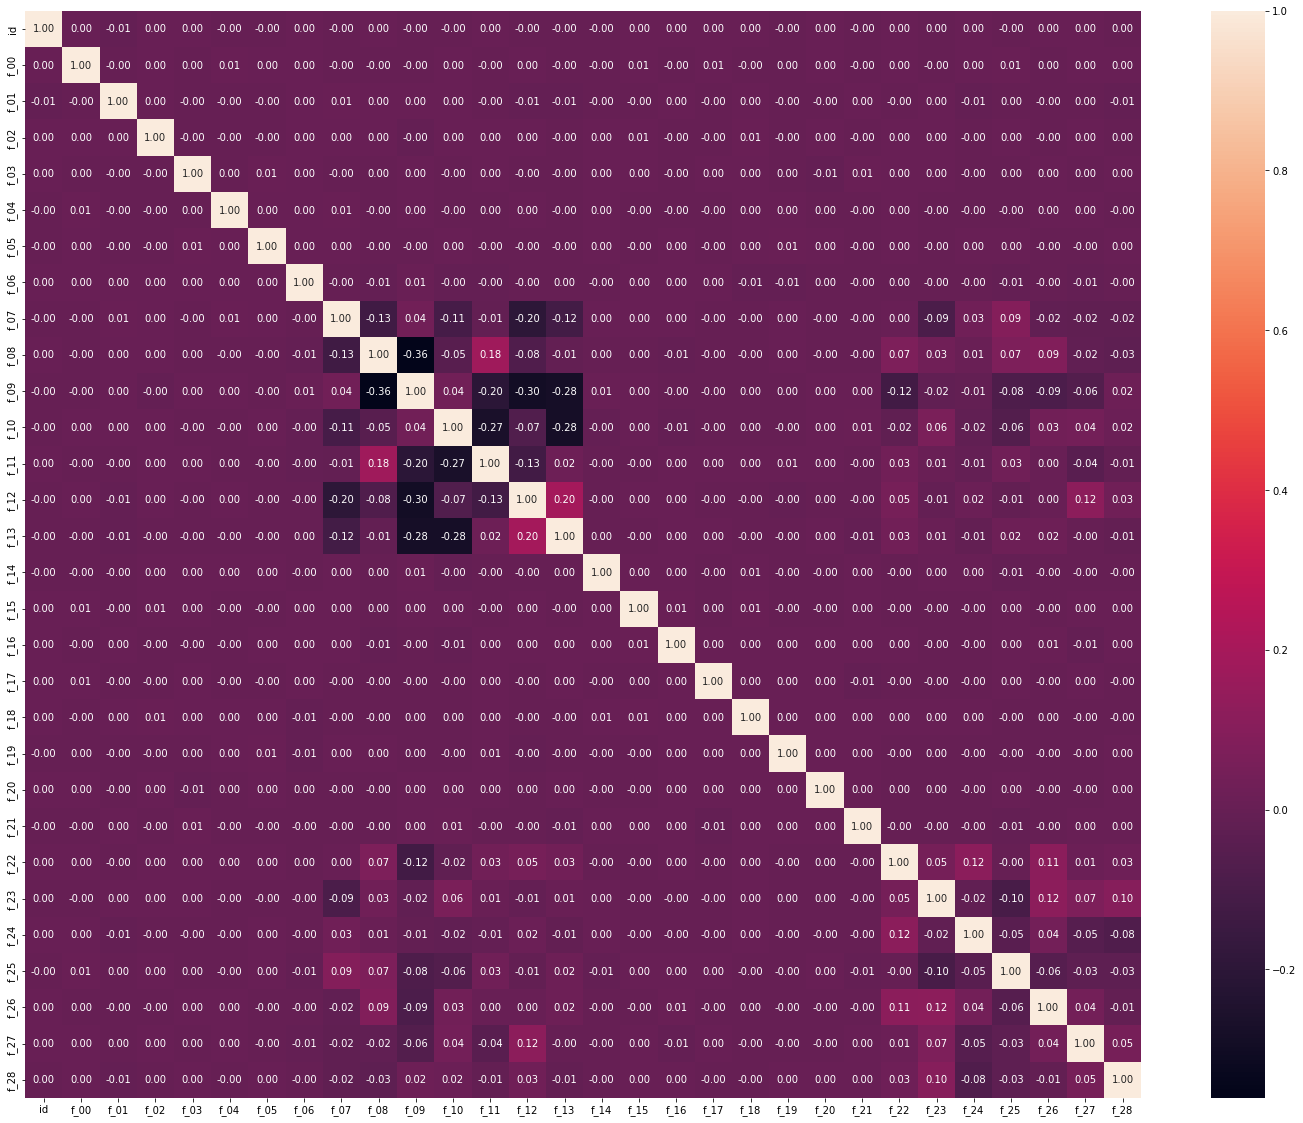

In [8]:
plt.figure(figsize=(25,20))
sns.heatmap(data.corr(),annot=True,fmt=".2f")

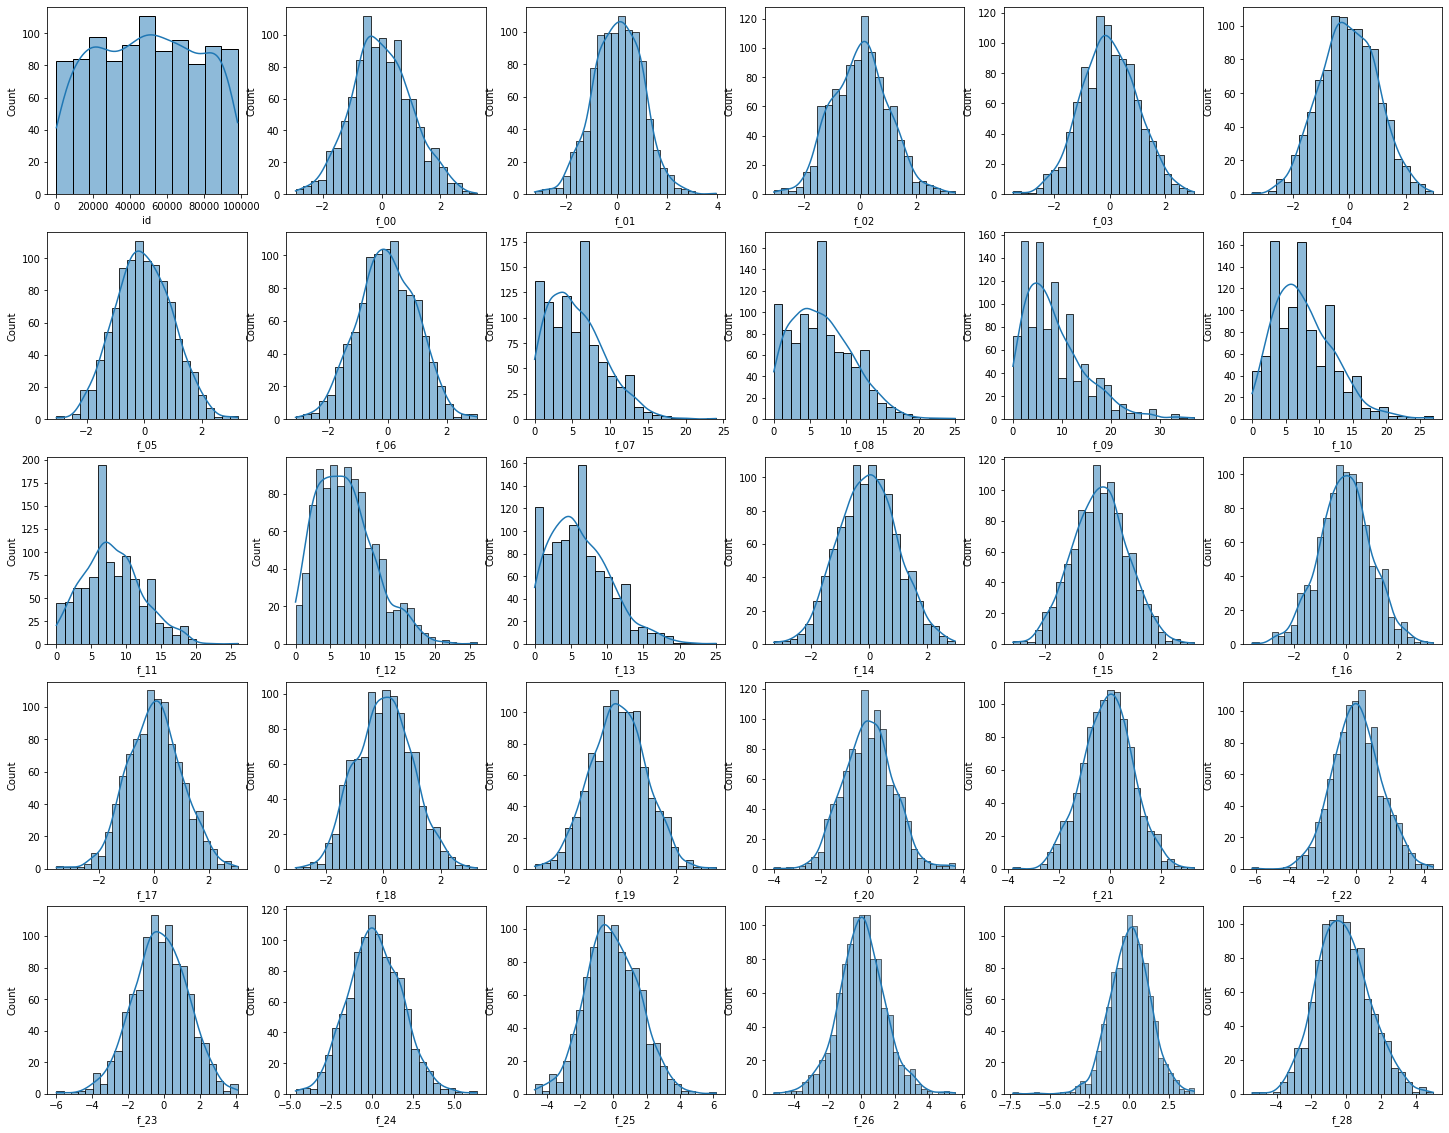

In [9]:
plt.figure(figsize=(25,20))
for i,column in enumerate(list(data.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x=column,data=data.sample(1000),kde=True)

**Feature Engineering**

In [10]:
data = data.drop(columns="id")

In [11]:
cols = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']

In [12]:
data_scaled = PowerTransformer(method="yeo-johnson").fit_transform(data[cols])

In [13]:
data_scaled = pd.DataFrame(data_scaled,columns=cols)
data_scaled.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373
3,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682
4,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058


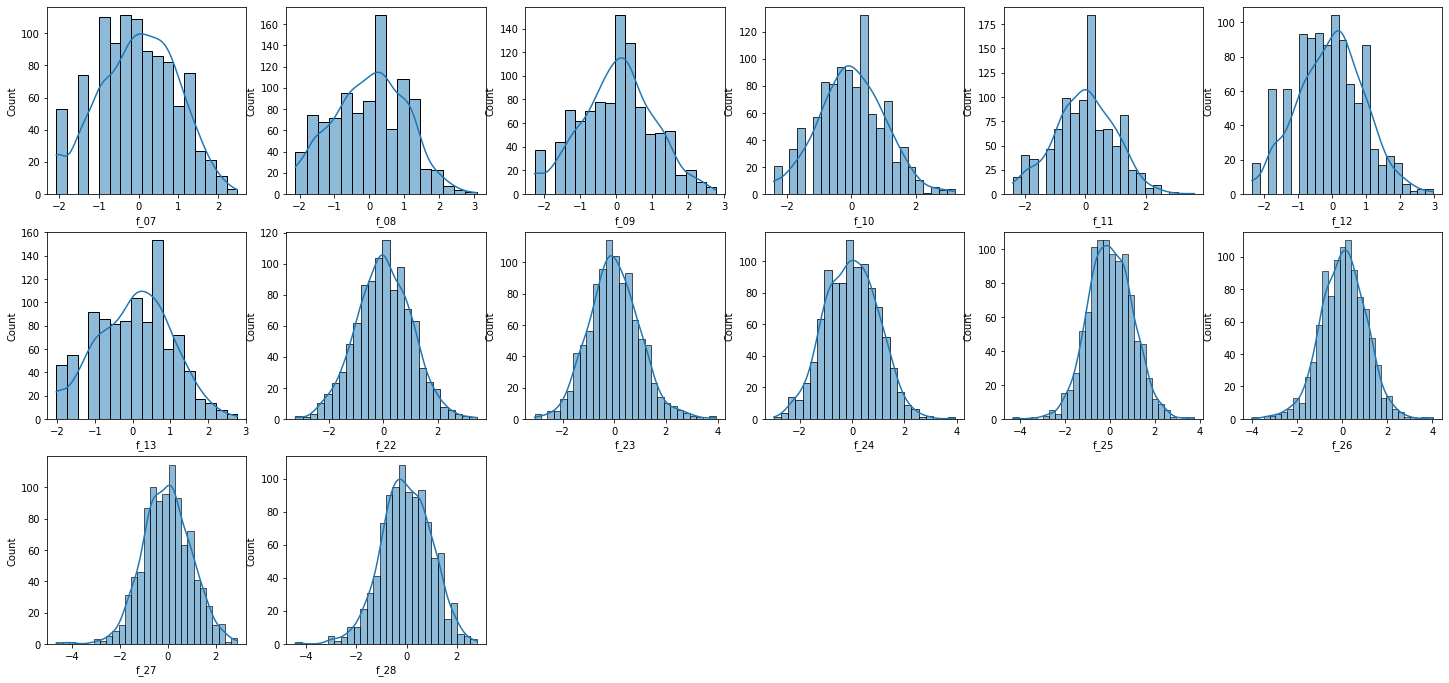

In [14]:
plt.figure(figsize=(25,20))
for i,column in enumerate(list(data_scaled.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x=column,data=data_scaled.sample(1000),kde=True)

**Model**

In [15]:
vbgmm = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=10)
preds = vbgmm.fit_predict(data_scaled)

**PCA**

<AxesSubplot:xlabel='x', ylabel='y'>

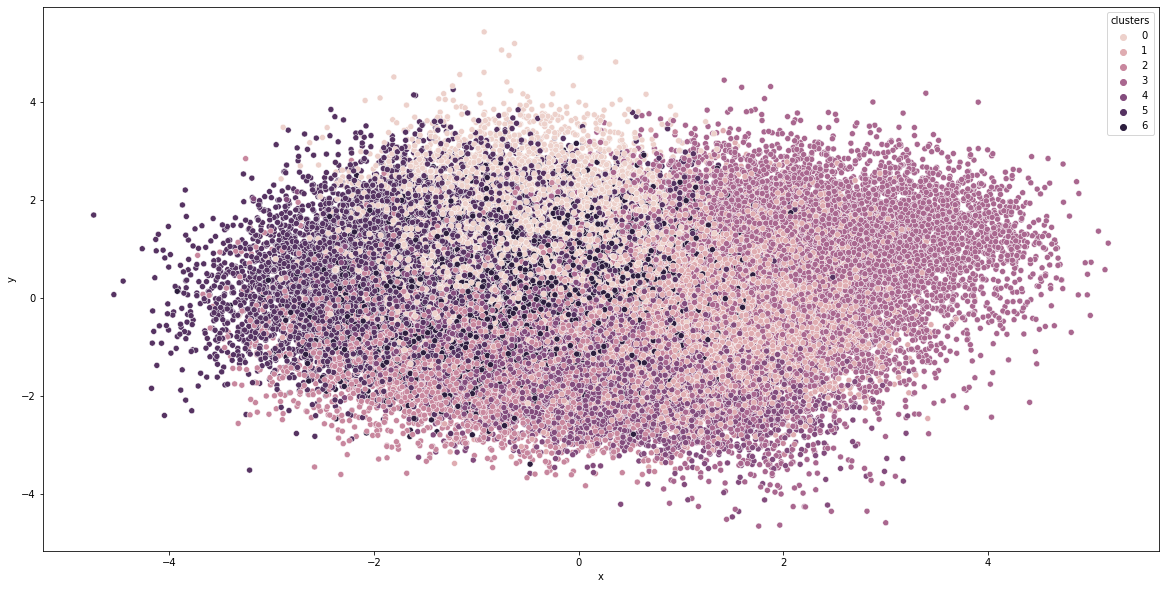

In [16]:
pca = PCA(n_components=7)
reduced_data = pca.fit_transform(data_scaled)
data = pd.DataFrame({"x" : reduced_data[:,0], "y" : reduced_data[:,1], "clusters" : preds})
plt.figure(figsize=(20, 10))
sns.scatterplot(x=data["x"], y=data["y"], hue=data["clusters"])

**Submission**

In [17]:
sub["Predicted"] = preds

In [18]:
sub.to_csv('submission.csv', index=False)